In [1]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [2]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from straightLoss import loss_func, bipartite_loss
from environment import Variables

2024-08-23 19:12:52.649139: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 19:12:52.691400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [4]:
dataMachine = data_handler.DataHandler()

In [5]:
img, label = dataMachine.augmentEpoch(30)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


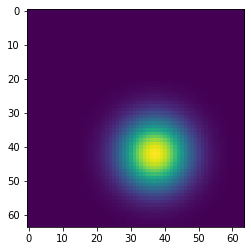

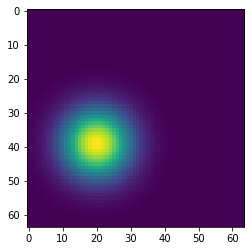

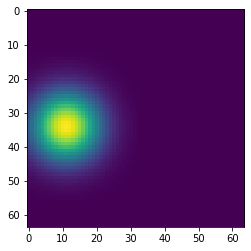

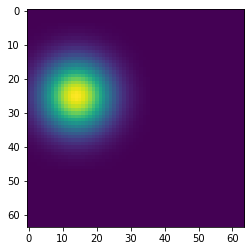

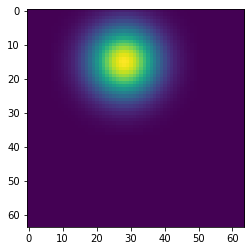

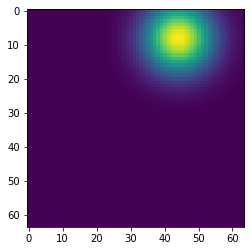

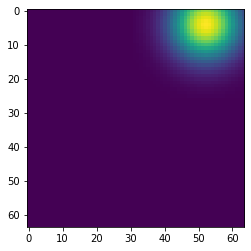

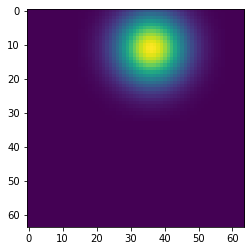

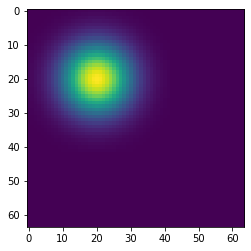

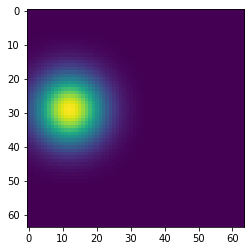

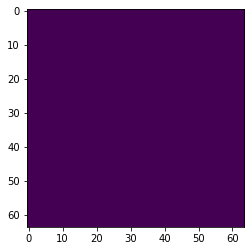

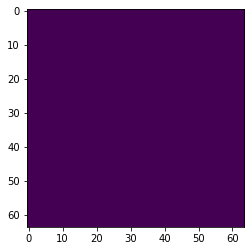

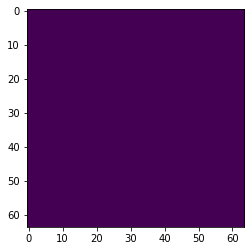

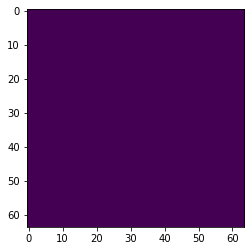

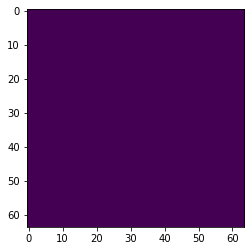

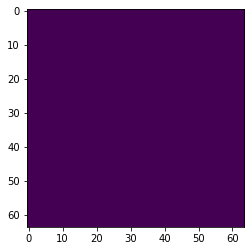

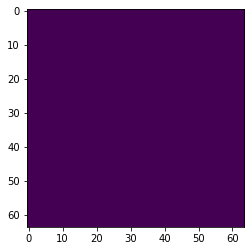

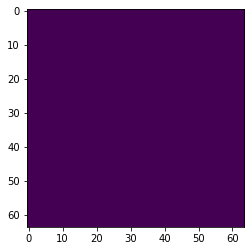

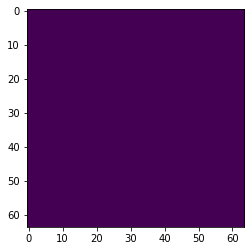

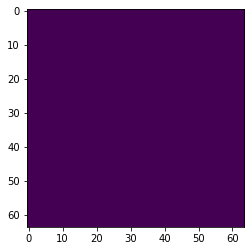

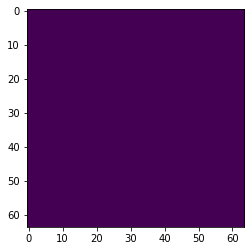

In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()

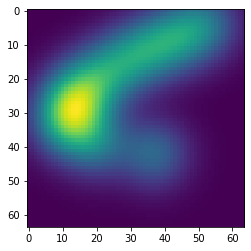

In [7]:
plt.imshow(np.sum(label[1],axis=0))

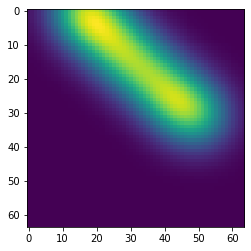

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [9]:
import tensorflow as tf

In [53]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    head_parts = tf.transpose(head_parts, (0, 3, 1, 2))
    reshaped_heatmaps = tf.reshape(head_parts, (tf.shape(head_parts)[0], 10, 64*64))
    softmax_heatmaps = tf.nn.softmax(reshaped_heatmaps, axis=-1)
    softmax_heatmaps = tf.reshape(softmax_heatmaps, (tf.shape(head_parts)[0], 10, 64, 64))
    head_parts = tf.transpose(head_parts, (0, 2, 3, 1))


    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [54]:
tf.config.run_functions_eagerly(False)

In [55]:
model = create_hourglass_network(10, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [56]:
model.compile(optimizer="Adam", loss=loss_func)

In [85]:
data = dataMachine.augmentEpoch(300)
permutation = np.random.permutation(len(data[0]))

shuffled_data1 = data[0][permutation]
shuffled_data2 = data[1][permutation]

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


In [ ]:
model.fit(tf.constant(shuffled_data1), tf.constant(shuffled_data2), batch_size=5,epochs=20)

In [78]:
out = model.predict(data[0])

10/10 [==============================] - 2s 168ms/step


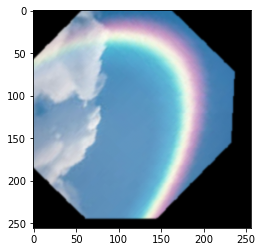

In [79]:
plt.imshow(data[0][5]/255.0)

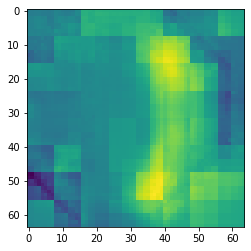

In [84]:
plt.imshow(np.sum(np.transpose(out[3][5],(2,0,1)),axis=0))

308.8681


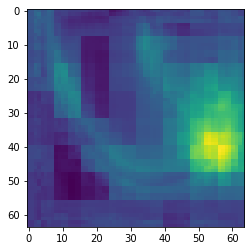

309.88638


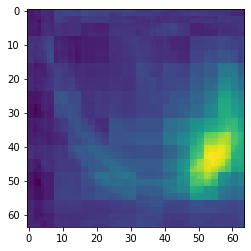

142.32436


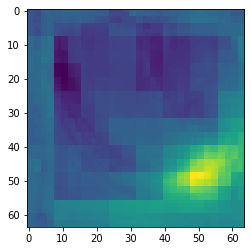

132.16103


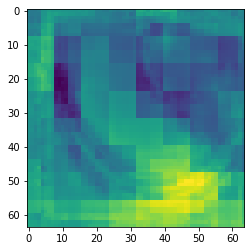

239.64972


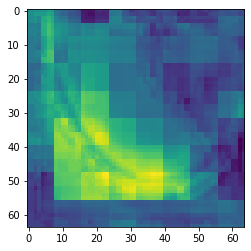

363.03937


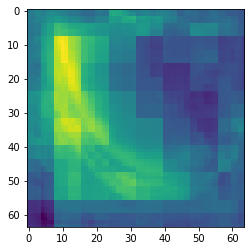

440.11395


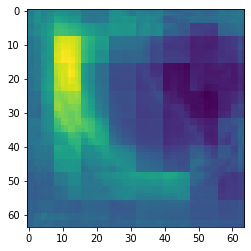

379.2887


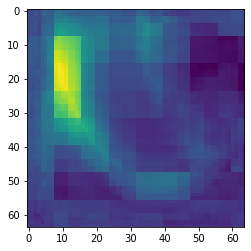

459.1507


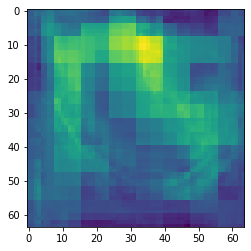

626.75366


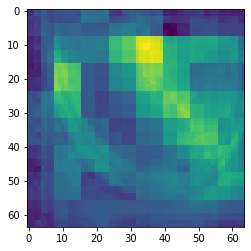

In [75]:
for x in np.transpose(out[3][5],(2,0,1)):
    print(np.sum(x))
    plt.imshow(x)
    plt.show()

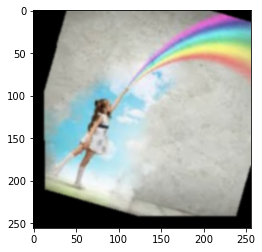

In [69]:
plt.imshow(data[0][20]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


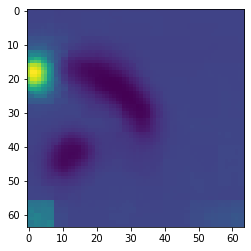

0.004737408


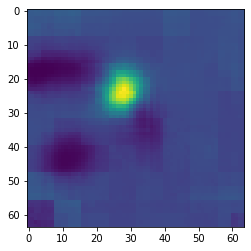

0.015574261


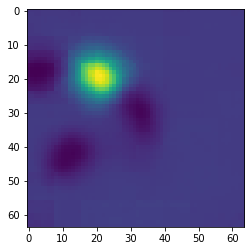

0.011428473


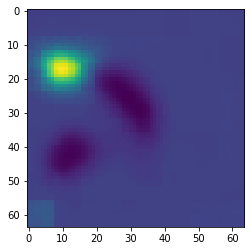

0.0055831005


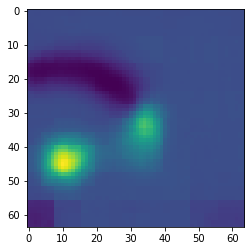

0.0073060193


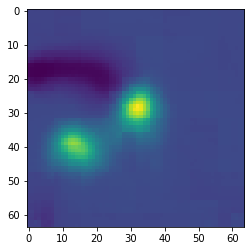

0.003621494


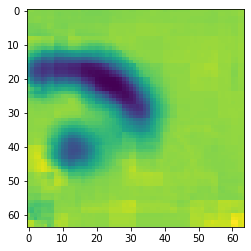

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


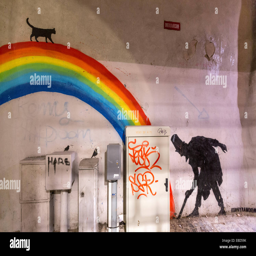

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

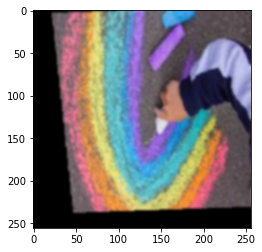

In [5]:
plt.imshow(img[1]/255.0)

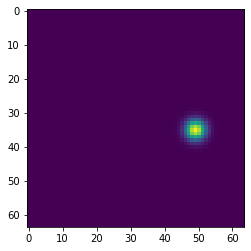

0


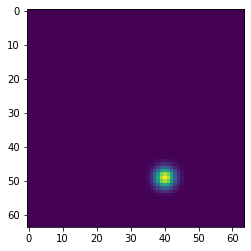

1


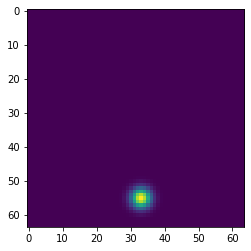

2


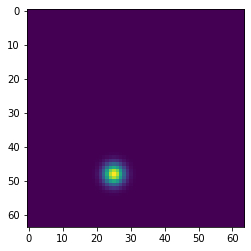

3


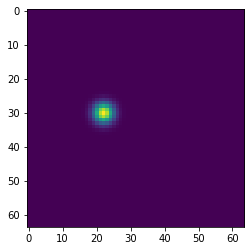

4


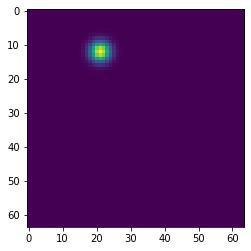

5


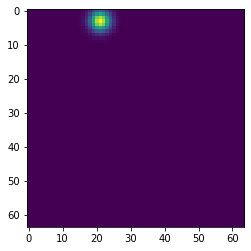

6


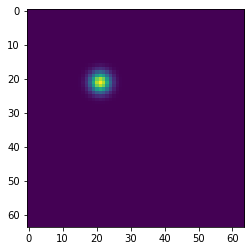

7


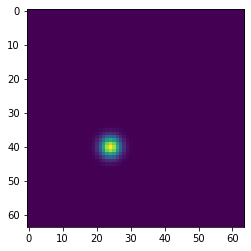

8


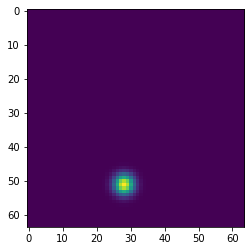

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

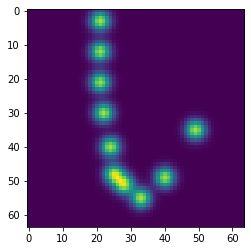

In [7]:
plt.imshow(np.sum(label[1],axis=0))

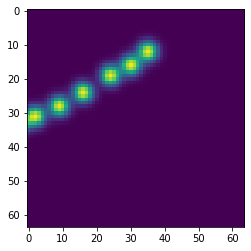

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

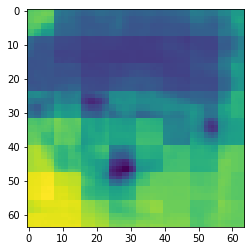

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


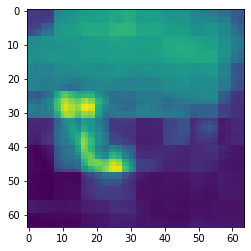

0.018625474


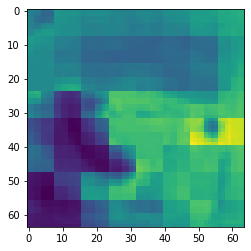

0.003564904


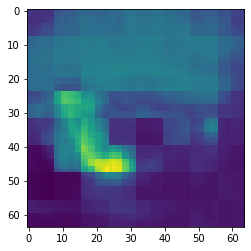

0.00058319094


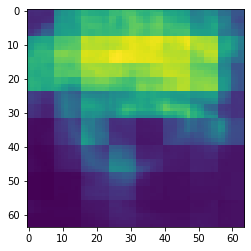

0.0023697943


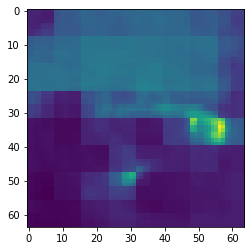

0.031174866


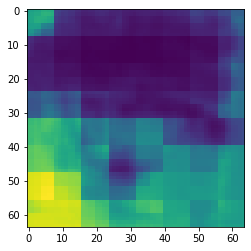

0.0022596146


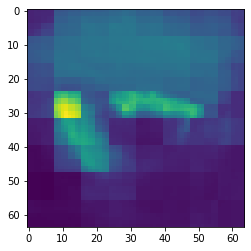

0.005172058


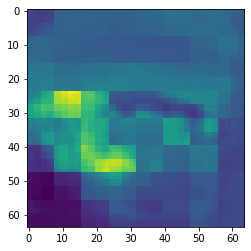

0.0013132769


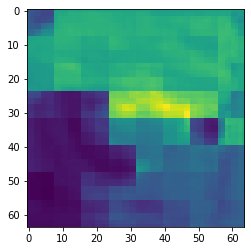

0.0035540778


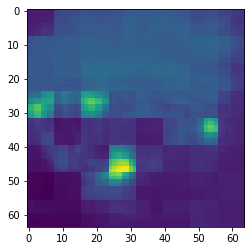

0.0017217919


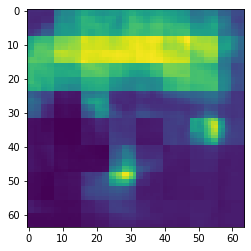

0.0019383262


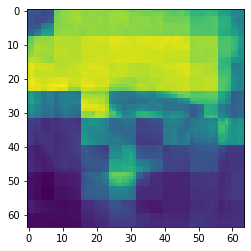

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

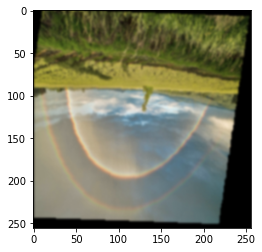

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


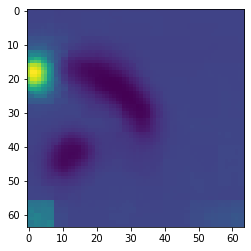

0.004737408


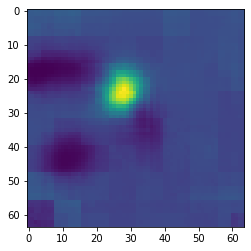

0.015574261


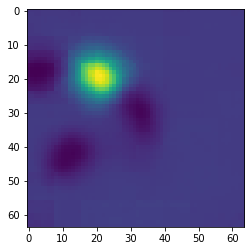

0.011428473


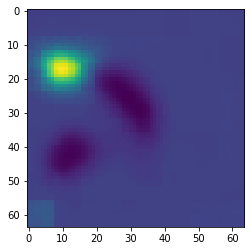

0.0055831005


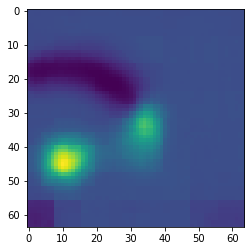

0.0073060193


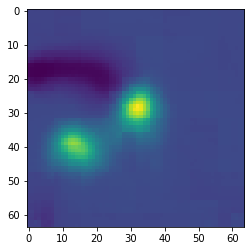

0.003621494


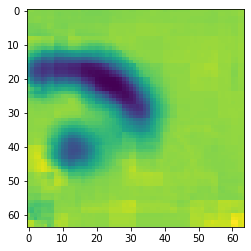

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


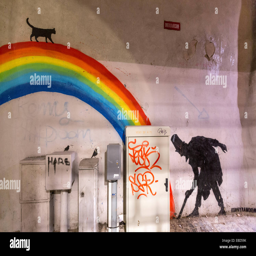

In [110]:
gah

In [ ]:
model.summary()

In [12]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [13]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from straightLoss import loss_func, bipartite_loss
from environment import Variables

2024-08-22 18:14:52.760729: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 18:14:52.827953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [15]:
dataMachine = data_handler.DataHandler()

In [16]:
img, label = dataMachine.augmentEpoch(30)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


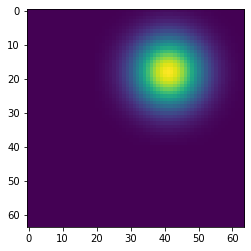

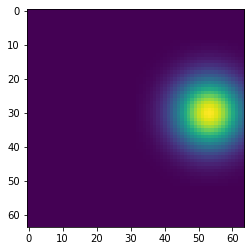

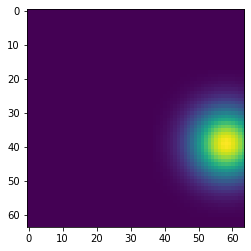

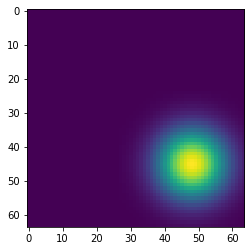

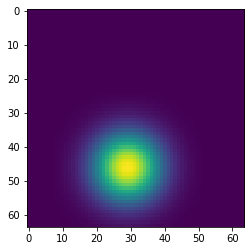

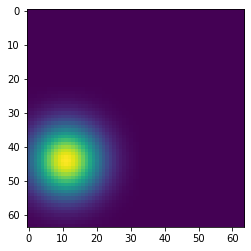

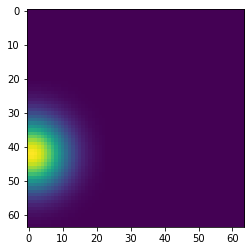

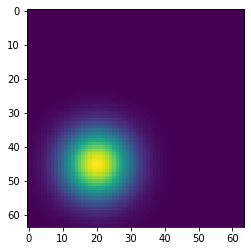

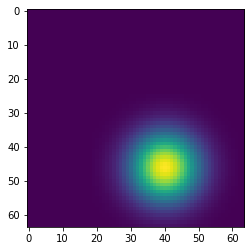

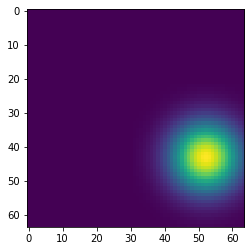

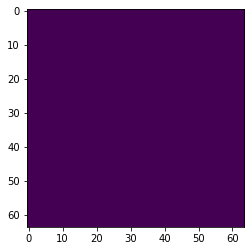

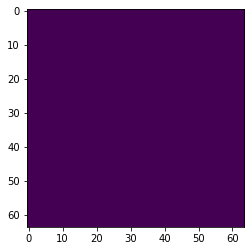

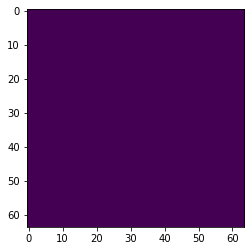

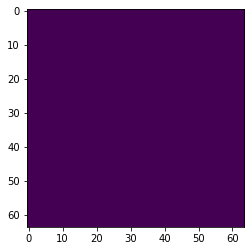

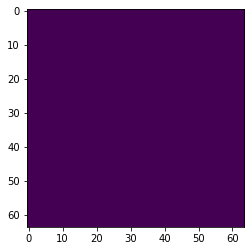

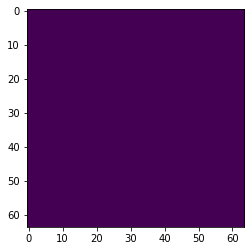

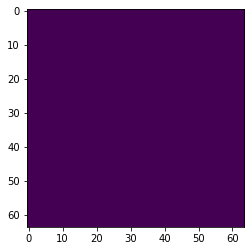

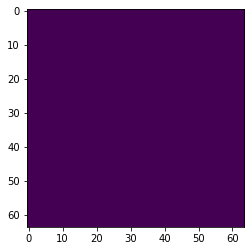

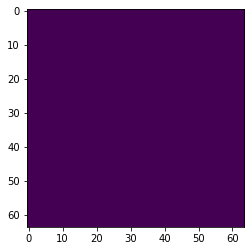

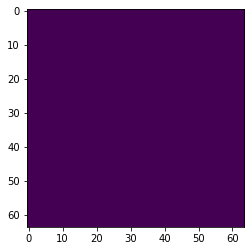

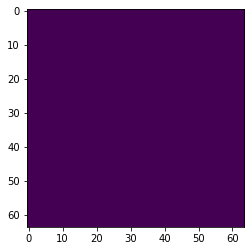

In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()

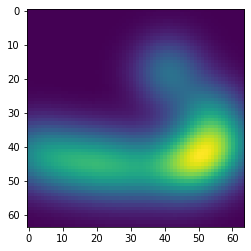

In [7]:
plt.imshow(np.sum(label[1],axis=0))

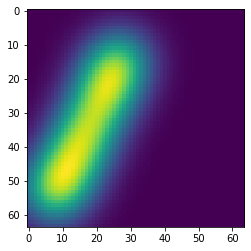

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [9]:
import tensorflow as tf

In [10]:
x = tf.constant(label[1])
y = tf.constant(label[7])
x = tf.cast(x,dtype=tf.float32)
y = tf.cast(y,dtype=tf.float32)

2024-08-22 18:08:36.135588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 18:08:36.180630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 18:08:36.184530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
y.shape

TensorShape([21, 64, 64])

In [12]:
x,y,z = bipartite_loss(x, y)

TypeError: Cannot iterate over a scalar tensor.

In [ ]:
x

In [ ]:
y = np.array(y)

In [ ]:
y[0,6]

In [ ]:
plt.imshow(y)

In [ ]:
z

In [ ]:
tf.reduce_mean(tf.gather_nd(y, z))

In [ ]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)
    head_parts = tf.nn.softmax(head_parts, axis=-1)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [46]:
tf.config.run_functions_eagerly(False)

In [47]:
model = create_hourglass_network(4, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [48]:
model.compile(optimizer="Adam", loss=loss_func)

In [49]:
data = dataMachine.augmentEpoch(300)
permutation = np.random.permutation(len(data[0]))

shuffled_data1 = data[0][permutation]
shuffled_data2 = data[1][permutation]

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


In [50]:
np.shape(shuffled_data1)

(300, 256, 256, 3)

In [51]:
np.shape(shuffled_data2)

(300, 21, 64, 64)

In [52]:
model.fit(tf.constant(shuffled_data1), tf.constant(shuffled_data2), batch_size=5,epochs=7)

Epoch 1/7
60/60 [==============================] - 123s 403ms/step - loss: 717.8660 - 0_conv_1x1_parts_softmax_loss: 188.3445 - 1_conv_1x1_parts_softmax_loss: 180.5894 - 2_conv_1x1_parts_softmax_loss: 173.2414 - 3_conv_1x1_parts_softmax_loss: 175.6906
Epoch 2/7
60/60 [==============================] - 24s 397ms/step - loss: 599.6397 - 0_conv_1x1_parts_softmax_loss: 159.6584 - 1_conv_1x1_parts_softmax_loss: 150.9877 - 2_conv_1x1_parts_softmax_loss: 143.6627 - 3_conv_1x1_parts_softmax_loss: 145.3309
Epoch 3/7
60/60 [==============================] - 24s 402ms/step - loss: 579.2083 - 0_conv_1x1_parts_softmax_loss: 148.6597 - 1_conv_1x1_parts_softmax_loss: 145.1747 - 2_conv_1x1_parts_softmax_loss: 144.4620 - 3_conv_1x1_parts_softmax_loss: 140.9119
Epoch 4/7
60/60 [==============================] - 24s 403ms/step - loss: 566.0148 - 0_conv_1x1_parts_softmax_loss: 141.8002 - 1_conv_1x1_parts_softmax_loss: 148.4278 - 2_conv_1x1_parts_softmax_loss: 137.1300 - 3_conv_1x1_parts_softmax_loss: 138.

In [53]:
out = model.predict(data[0])

10/10 [==============================] - 4s 167ms/step


In [54]:
np.shape(out)

(4, 300, 64, 64, 4)

AttributeError: 'AxesImage' object has no property 'axis'

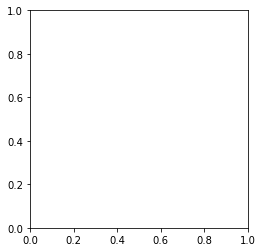

In [58]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1)),axis=0))

0.0859652


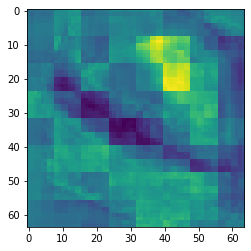

0.15220161


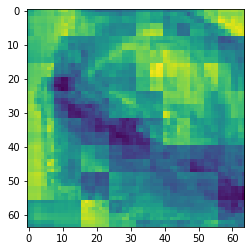

0.09265042


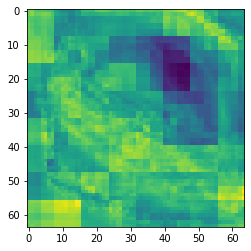

0.11971648


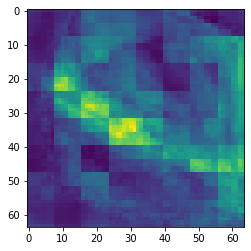

In [56]:
for x in np.transpose(out[0][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

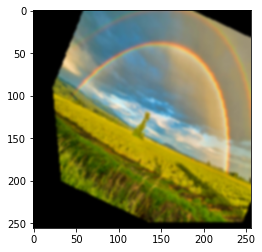

In [57]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


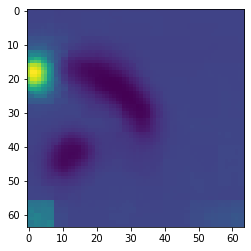

0.004737408


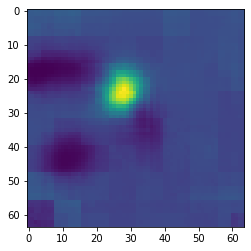

0.015574261


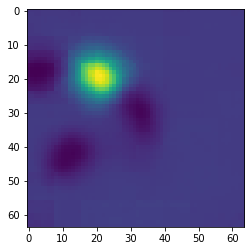

0.011428473


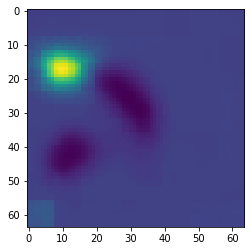

0.0055831005


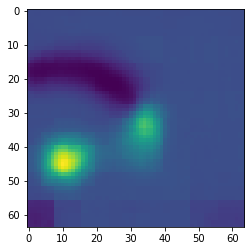

0.0073060193


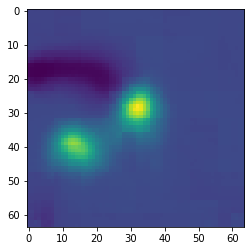

0.003621494


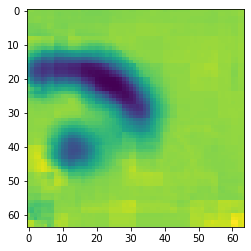

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


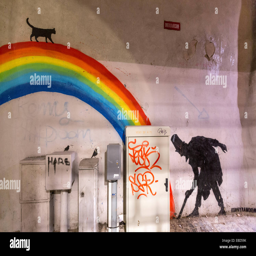

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

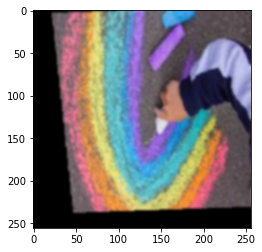

In [5]:
plt.imshow(img[1]/255.0)

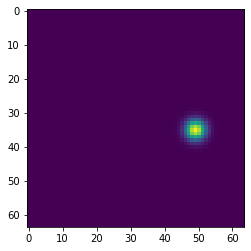

0


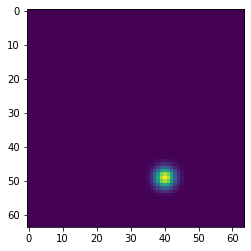

1


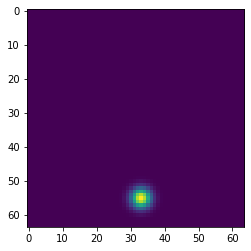

2


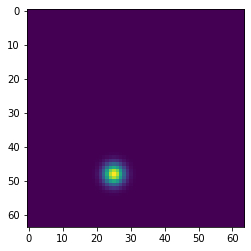

3


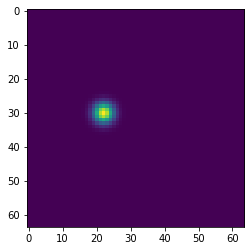

4


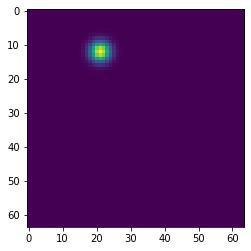

5


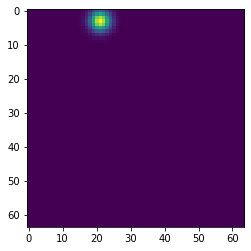

6


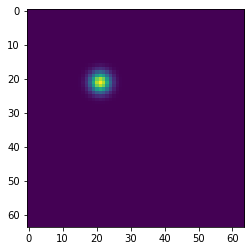

7


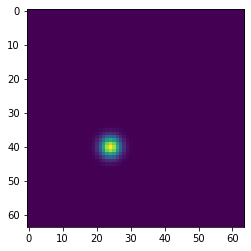

8


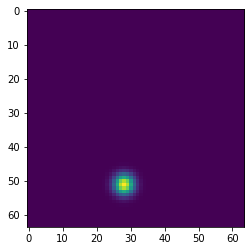

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

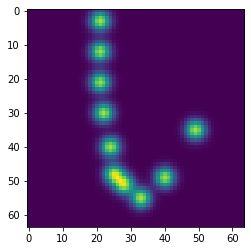

In [7]:
plt.imshow(np.sum(label[1],axis=0))

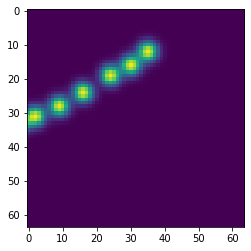

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

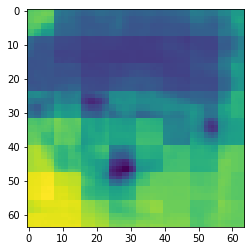

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


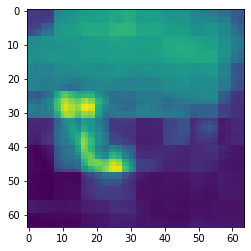

0.018625474


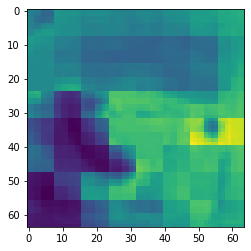

0.003564904


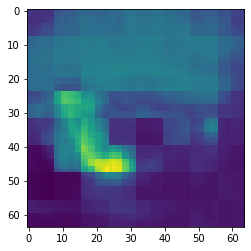

0.00058319094


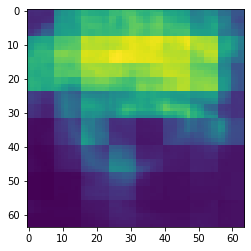

0.0023697943


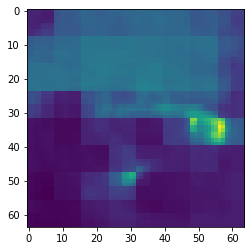

0.031174866


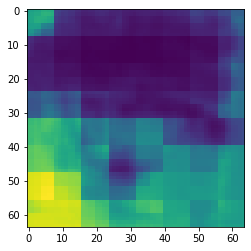

0.0022596146


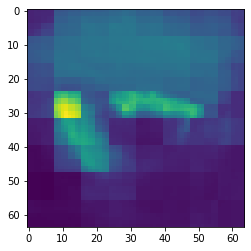

0.005172058


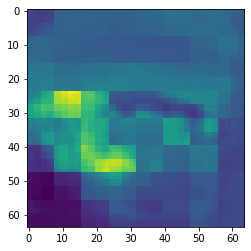

0.0013132769


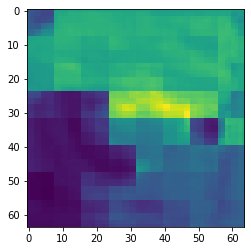

0.0035540778


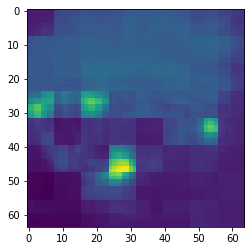

0.0017217919


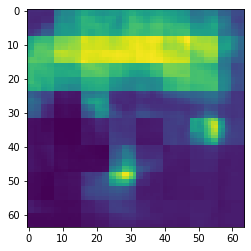

0.0019383262


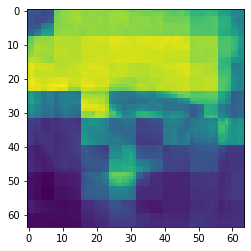

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

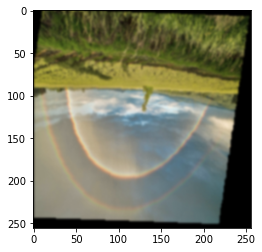

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


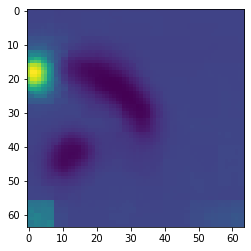

0.004737408


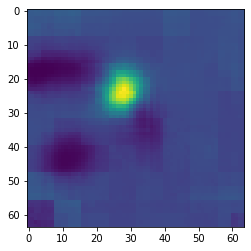

0.015574261


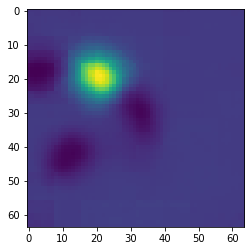

0.011428473


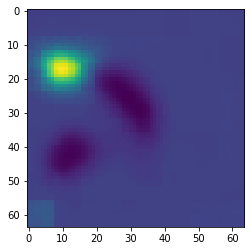

0.0055831005


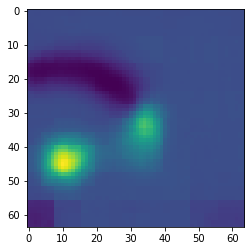

0.0073060193


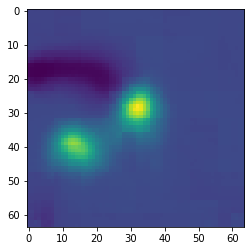

0.003621494


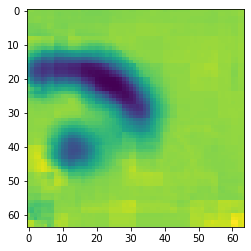

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


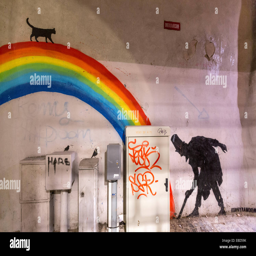

In [110]:
gah

In [ ]:
model.summary()

In [82]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [83]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from straightLoss import loss_func, bipartite_loss
from environment import Variables

In [84]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [85]:
dataMachine = data_handler.DataHandler()

In [86]:
img, label = dataMachine.augmentEpoch(30)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


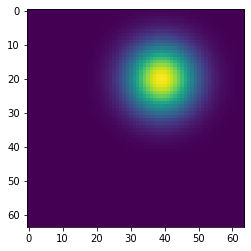

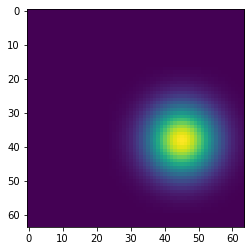

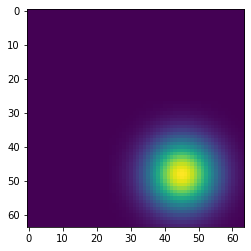

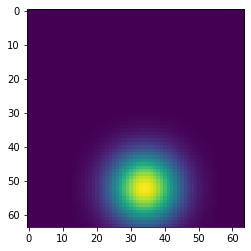

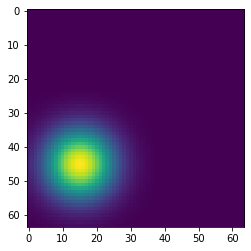

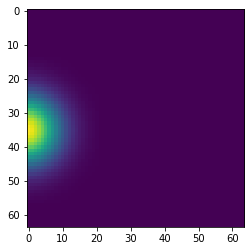

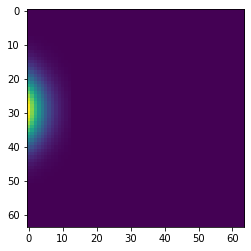

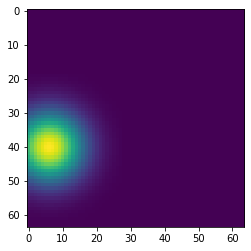

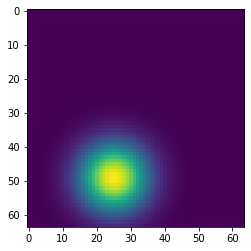

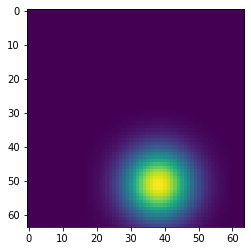

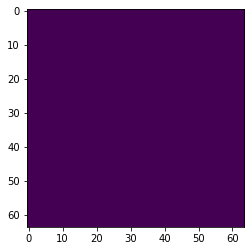

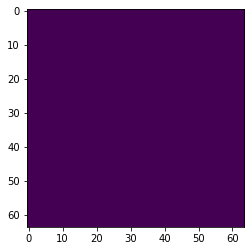

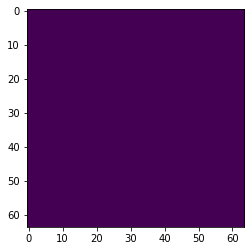

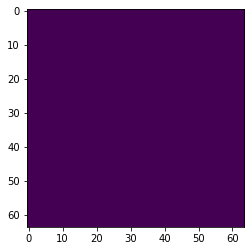

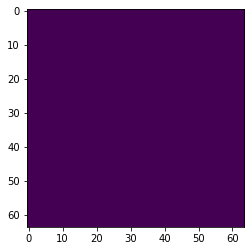

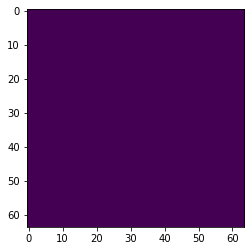

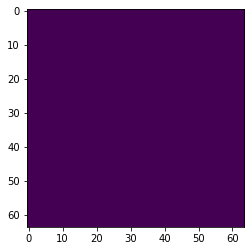

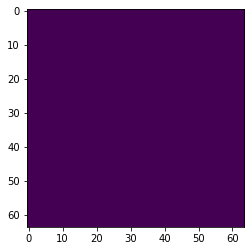

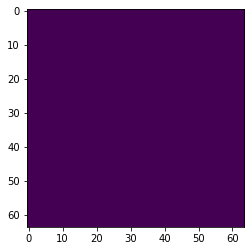

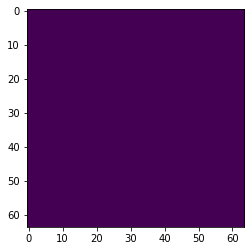

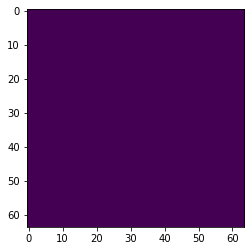

In [87]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()

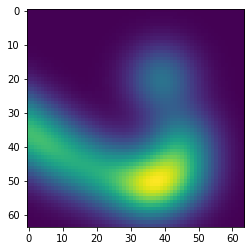

In [88]:
plt.imshow(np.sum(label[1],axis=0))

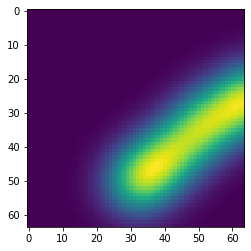

In [89]:
plt.imshow(np.sum(label[7],axis=0))

In [90]:
import tensorflow as tf

In [91]:
x = tf.constant(label[1])
y = tf.constant(label[7])
x = tf.cast(x,dtype=tf.float32)
y = tf.cast(y,dtype=tf.float32)

In [92]:
y.shape

TensorShape([21, 64, 64])

In [93]:
x,y,z = bipartite_loss(x, y)

TypeError: Cannot iterate over a scalar tensor.

In [ ]:
x

In [ ]:
y = np.array(y)

In [ ]:
y[0,6]

In [ ]:
plt.imshow(y)

In [ ]:
z

In [ ]:
tf.reduce_mean(tf.gather_nd(y, z))

In [122]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)
    print("Shape before softmax:", head_parts.shape)
    head_parts = tf.nn.softmax(logits, axis=3)


    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [128]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D

# Assuming head_parts is your input tensor with shape (batch_size, 64, 64, previous_channels)
batch_size = 3  # Example batch size
num_classes = 7  # Example number of classes (channels in the output)
hgid = 1  # Example ID

# Example input tensor
head_parts = tf.random.uniform((batch_size, 64, 64, num_classes))

# Apply Conv2D without softmax first
head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation=None, padding='same', name=str(hgid) + '_conv_1x1_parts')(head_parts)

# Print the shape before applying softmax
print("Shape before softmax:", head_parts.shape)

# Reshape to ensure correct softmax application
# head_parts = tf.transpose(head_parts, [0, 2, 3, 1])  # (batch_size, 64, 64, 7)

# Apply softmax on the last axis (axis=-1)
head_parts = tf.nn.softmax(head_parts, axis=3)

# If necessary, transpose back to the original shape
# head_parts = tf.transpose(head_parts, [0, 3, 1, 2])  

print("Shape before softmax:", head_parts.shape)

Shape before softmax: (3, 64, 64, 7)
Shape before softmax: (3, 64, 64, 7)


In [132]:
gah = np.array(tf.transpose(head_parts, (0,3,1,2)))

In [136]:
np.sum(gah[0],axis=0)

array([[0.9999999 , 0.9999999 , 1.        , ..., 1.        , 1.        ,
        0.99999994],
       [0.99999994, 0.99999994, 1.        , ..., 1.0000001 , 1.0000001 ,
        1.        ],
       [1.0000001 , 1.0000001 , 0.99999994, ..., 0.99999994, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.0000001 ,
        1.        ],
       [0.99999994, 1.        , 1.        , ..., 1.        , 1.        ,
        0.9999999 ],
       [1.0000001 , 0.9999999 , 1.        , ..., 0.9999999 , 1.        ,
        1.        ]], dtype=float32)

In [118]:
tf.config.run_functions_eagerly(False)

In [119]:
model = create_hourglass_network(4, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

Shape before softmax: (None, 64, 64, 4)
Shape before softmax: (None, 64, 64, 4)
Shape before softmax: (None, 64, 64, 4)
Shape before softmax: (None, 64, 64, 4)


In [ ]:
model.compile(optimizer="Adam", loss=loss_func)

In [113]:
data = dataMachine.augmentEpoch(30)
permutation = np.random.permutation(len(data[0]))

shuffled_data1 = data[0][permutation]
shuffled_data2 = data[1][permutation]

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


In [114]:
np.shape(shuffled_data1)

(30, 256, 256, 3)

In [115]:
np.shape(shuffled_data2)

(30, 21, 64, 64)

In [116]:
model.fit(tf.constant(shuffled_data1), tf.constant(shuffled_data2), batch_size=5,epochs=7)

Epoch 1/7
6/6 [==============================] - 2s 390ms/step - loss: 582.4266 - tf.nn.softmax_4_loss: 143.2313 - tf.nn.softmax_5_loss: 148.3102 - tf.nn.softmax_6_loss: 144.4103 - tf.nn.softmax_7_loss: 146.4748
Epoch 2/7
6/6 [==============================] - 2s 391ms/step - loss: 589.3796 - tf.nn.softmax_4_loss: 140.8285 - tf.nn.softmax_5_loss: 161.4540 - tf.nn.softmax_6_loss: 142.7545 - tf.nn.softmax_7_loss: 144.3425
Epoch 3/7
6/6 [==============================] - 2s 405ms/step - loss: 570.1655 - tf.nn.softmax_4_loss: 145.9429 - tf.nn.softmax_5_loss: 139.1006 - tf.nn.softmax_6_loss: 143.1192 - tf.nn.softmax_7_loss: 142.0028
Epoch 4/7
6/6 [==============================] - 2s 392ms/step - loss: 601.6082 - tf.nn.softmax_4_loss: 148.1865 - tf.nn.softmax_5_loss: 162.6523 - tf.nn.softmax_6_loss: 139.1630 - tf.nn.softmax_7_loss: 151.6064
Epoch 5/7
6/6 [==============================] - 2s 404ms/step - loss: 532.4019 - tf.nn.softmax_4_loss: 145.7536 - tf.nn.softmax_5_loss: 152.3509 - tf.n

In [104]:
out = model.predict(data[0])

10/10 [==============================] - 4s 170ms/step


In [105]:
np.shape(out)

(4, 300, 64, 64, 4)

In [107]:
np.sum(np.transpose(out[3][0],(2,0,1)),axis=0)

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.9999999 ],
       [1.        , 1.        , 1.0000001 , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.9999999 ],
       ...,
       [1.        , 0.99999994, 1.        , ..., 0.99999994, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.0000001 , 1.        ,
        0.9999999 ],
       [1.        , 1.        , 0.99999994, ..., 1.        , 1.        ,
        0.99999994]], dtype=float32)

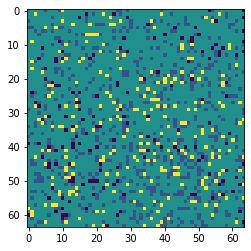

In [106]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1)),axis=0))

0.08424271


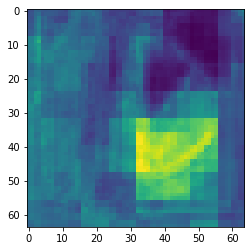

0.16611764


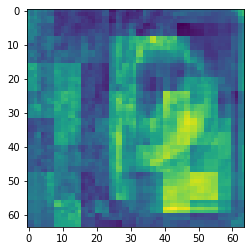

0.14222965


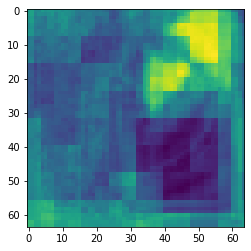

0.10596439


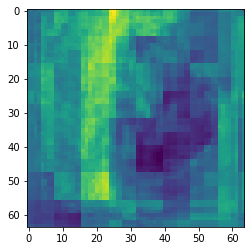

In [108]:
for x in np.transpose(out[0][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

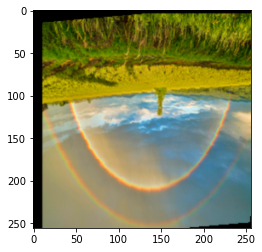

In [50]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


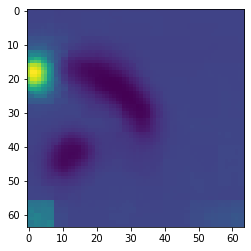

0.004737408


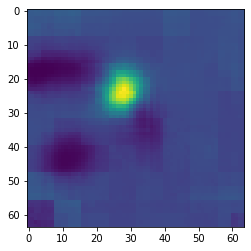

0.015574261


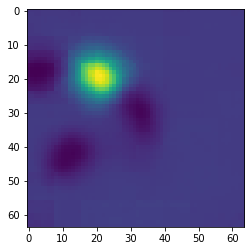

0.011428473


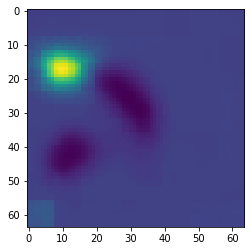

0.0055831005


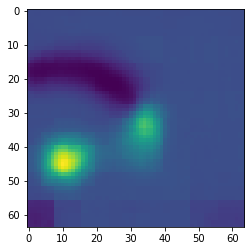

0.0073060193


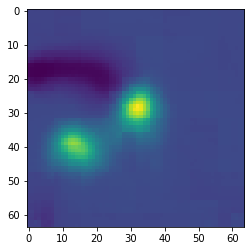

0.003621494


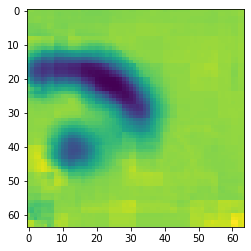

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


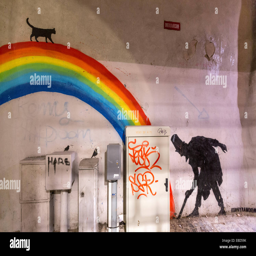

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

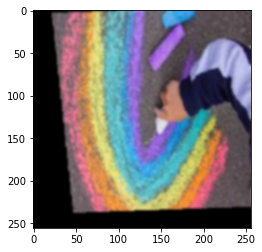

In [5]:
plt.imshow(img[1]/255.0)

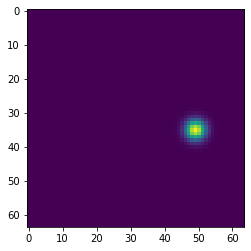

0


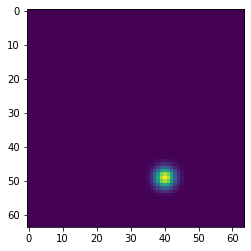

1


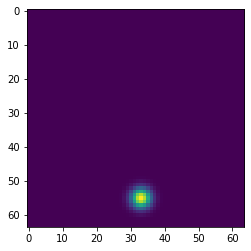

2


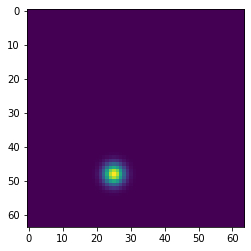

3


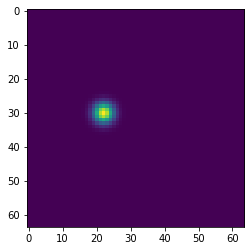

4


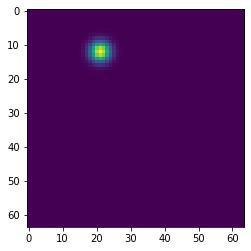

5


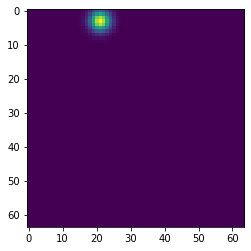

6


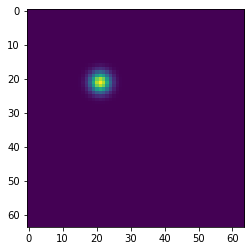

7


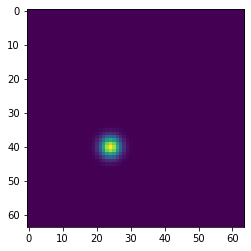

8


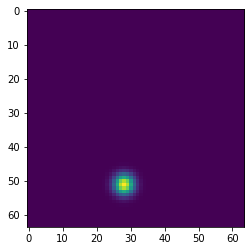

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

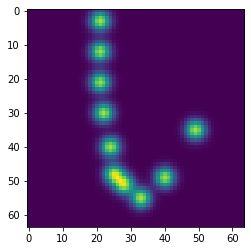

In [7]:
plt.imshow(np.sum(label[1],axis=0))

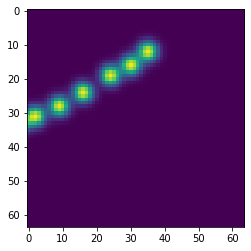

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

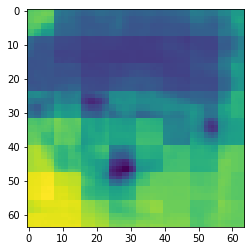

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


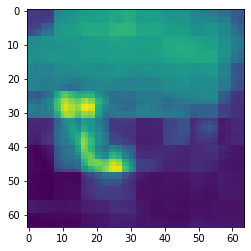

0.018625474


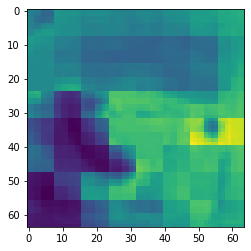

0.003564904


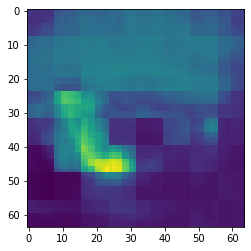

0.00058319094


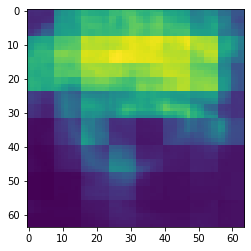

0.0023697943


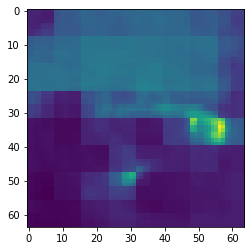

0.031174866


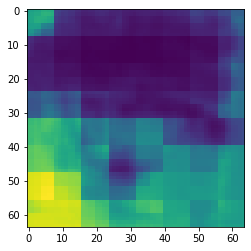

0.0022596146


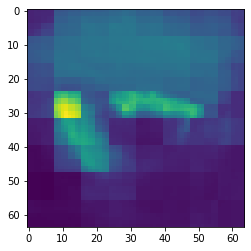

0.005172058


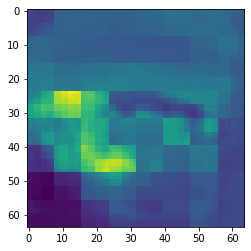

0.0013132769


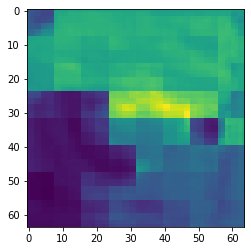

0.0035540778


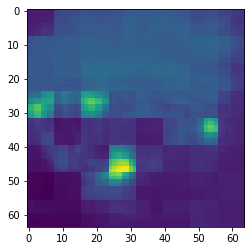

0.0017217919


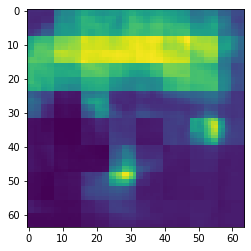

0.0019383262


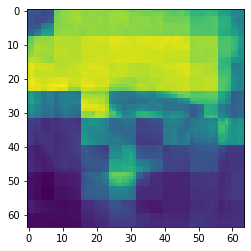

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

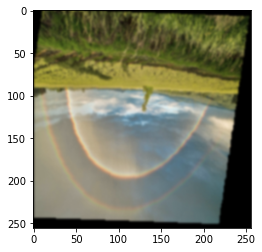

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


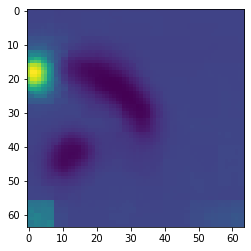

0.004737408


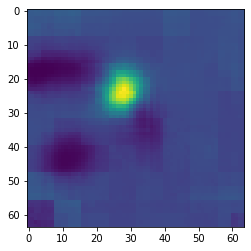

0.015574261


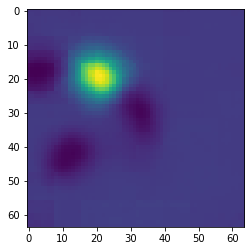

0.011428473


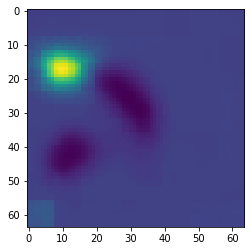

0.0055831005


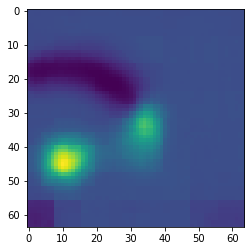

0.0073060193


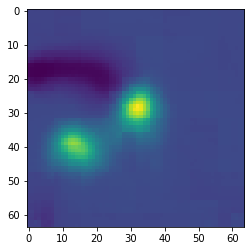

0.003621494


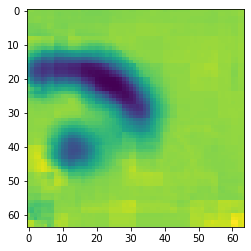

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


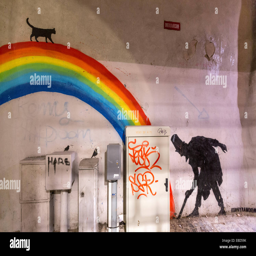

In [110]:
gah

In [ ]:
model.summary()

In [12]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization
#Deal with ragged tensors by creating horrid heatmaps that wont match

In [13]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from straightLoss import loss_func, bipartite_loss
from environment import Variables

2024-08-22 18:14:52.760729: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 18:14:52.827953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [15]:
dataMachine = data_handler.DataHandler()

In [16]:
img, label = dataMachine.augmentEpoch(30)

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


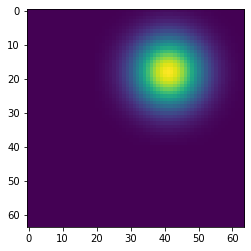

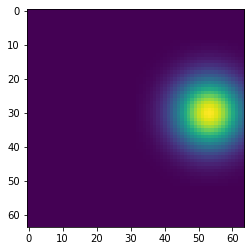

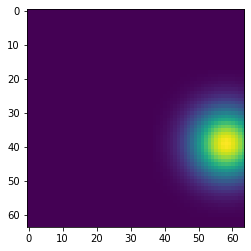

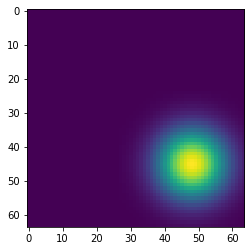

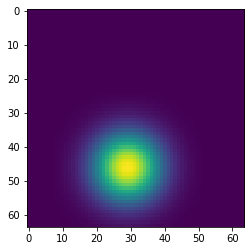

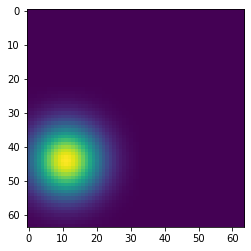

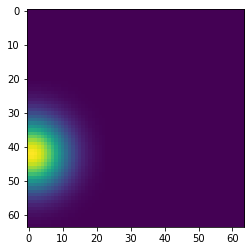

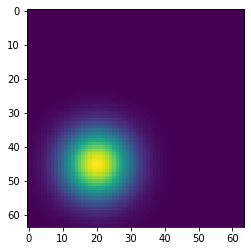

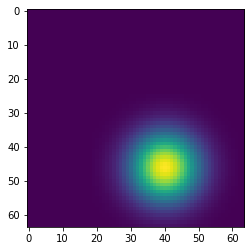

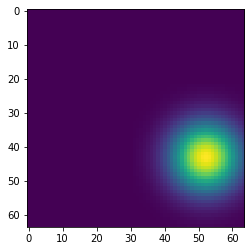

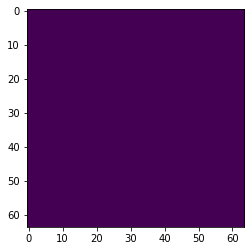

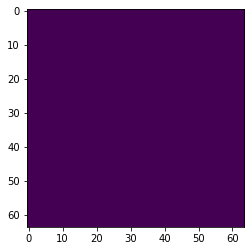

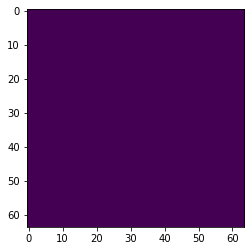

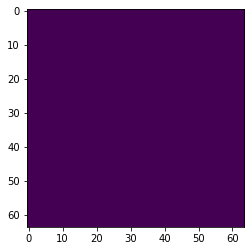

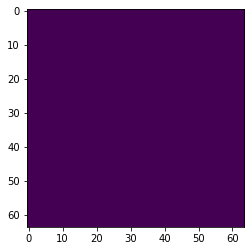

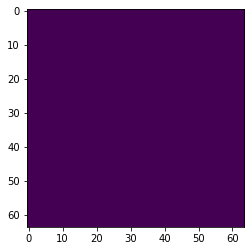

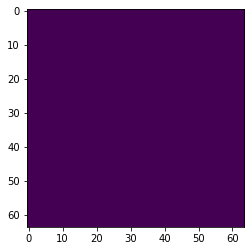

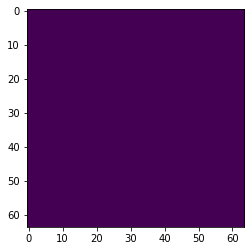

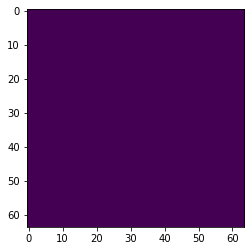

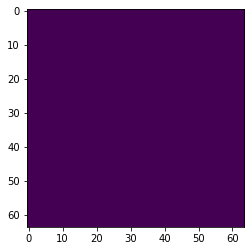

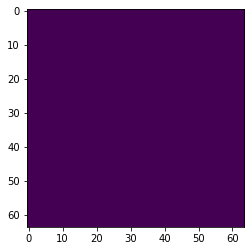

In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()

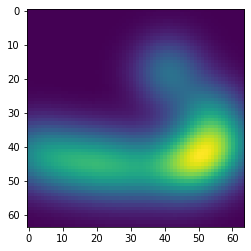

In [7]:
plt.imshow(np.sum(label[1],axis=0))

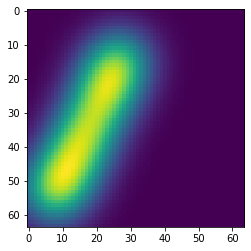

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [9]:
import tensorflow as tf

In [10]:
x = tf.constant(label[1])
y = tf.constant(label[7])
x = tf.cast(x,dtype=tf.float32)
y = tf.cast(y,dtype=tf.float32)

2024-08-22 18:08:36.135588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 18:08:36.180630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-22 18:08:36.184530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
y.shape

TensorShape([21, 64, 64])

In [12]:
x,y,z = bipartite_loss(x, y)

TypeError: Cannot iterate over a scalar tensor.

In [ ]:
x

In [ ]:
y = np.array(y)

In [ ]:
y[0,6]

In [ ]:
plt.imshow(y)

In [ ]:
z

In [ ]:
tf.reduce_mean(tf.gather_nd(y, z))

In [ ]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)
    head_parts = tf.nn.softmax(head_parts, axis=-1)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [46]:
tf.config.run_functions_eagerly(False)

In [47]:
model = create_hourglass_network(4, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [48]:
model.compile(optimizer="Adam", loss=loss_func)

In [49]:
data = dataMachine.augmentEpoch(300)
permutation = np.random.permutation(len(data[0]))

shuffled_data1 = data[0][permutation]
shuffled_data2 = data[1][permutation]

10
10
8
6
9
8
10
7
11
7
7
9
7
8
9
21
7
10
10
9
5
9
9
6
4
10
8
5
8
8


In [50]:
np.shape(shuffled_data1)

(300, 256, 256, 3)

In [51]:
np.shape(shuffled_data2)

(300, 21, 64, 64)

In [52]:
model.fit(tf.constant(shuffled_data1), tf.constant(shuffled_data2), batch_size=5,epochs=7)

Epoch 1/7
60/60 [==============================] - 123s 403ms/step - loss: 717.8660 - 0_conv_1x1_parts_softmax_loss: 188.3445 - 1_conv_1x1_parts_softmax_loss: 180.5894 - 2_conv_1x1_parts_softmax_loss: 173.2414 - 3_conv_1x1_parts_softmax_loss: 175.6906
Epoch 2/7
60/60 [==============================] - 24s 397ms/step - loss: 599.6397 - 0_conv_1x1_parts_softmax_loss: 159.6584 - 1_conv_1x1_parts_softmax_loss: 150.9877 - 2_conv_1x1_parts_softmax_loss: 143.6627 - 3_conv_1x1_parts_softmax_loss: 145.3309
Epoch 3/7
60/60 [==============================] - 24s 402ms/step - loss: 579.2083 - 0_conv_1x1_parts_softmax_loss: 148.6597 - 1_conv_1x1_parts_softmax_loss: 145.1747 - 2_conv_1x1_parts_softmax_loss: 144.4620 - 3_conv_1x1_parts_softmax_loss: 140.9119
Epoch 4/7
60/60 [==============================] - 24s 403ms/step - loss: 566.0148 - 0_conv_1x1_parts_softmax_loss: 141.8002 - 1_conv_1x1_parts_softmax_loss: 148.4278 - 2_conv_1x1_parts_softmax_loss: 137.1300 - 3_conv_1x1_parts_softmax_loss: 138.

In [53]:
out = model.predict(data[0])

10/10 [==============================] - 4s 167ms/step


In [54]:
np.shape(out)

(4, 300, 64, 64, 4)

AttributeError: 'AxesImage' object has no property 'axis'

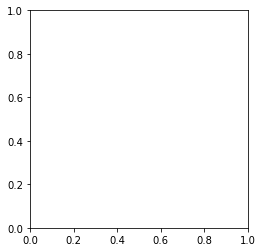

In [58]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1)),axis=0))

0.0859652


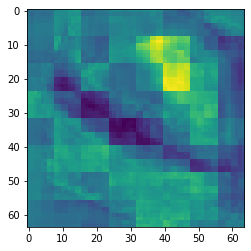

0.15220161


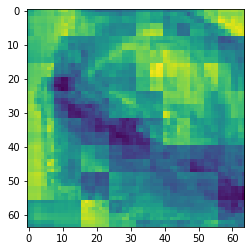

0.09265042


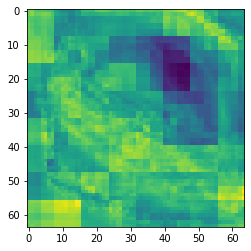

0.11971648


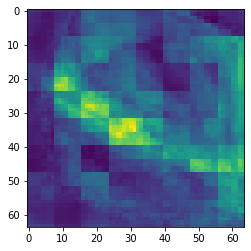

In [56]:
for x in np.transpose(out[0][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

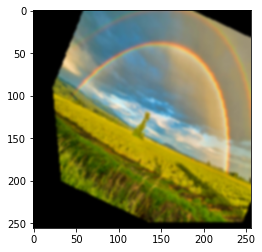

In [57]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


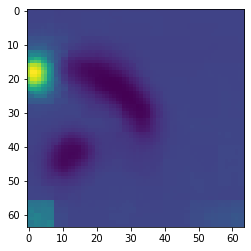

0.004737408


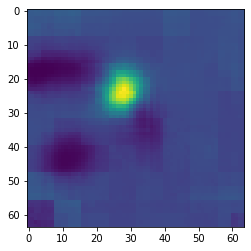

0.015574261


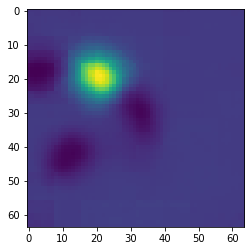

0.011428473


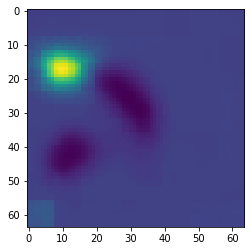

0.0055831005


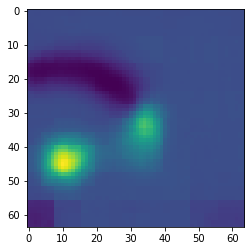

0.0073060193


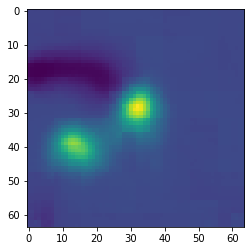

0.003621494


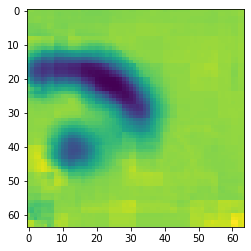

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


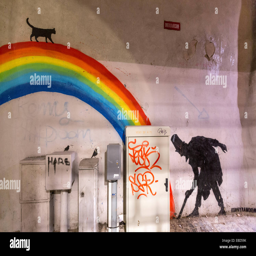

In [110]:
gah

In [ ]:
model.summary()

In [ ]:
#DNST LAYER
#Find the best number of keypoints to output
#Shuffling data
#Configuring model layout with softmax layers, Softmax useful??
#GPU optimization

In [1]:
import sys
sys.path.append('dataset')
sys.path.append('loss')

import data_handler
from newLoss import loss_func
from environment import Variables

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

In [3]:
dataMachine = data_handler.DataHandler()

In [4]:
img, label = dataMachine.augmentEpoch(30)

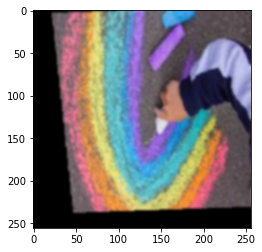

In [5]:
plt.imshow(img[1]/255.0)

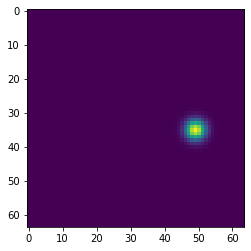

0


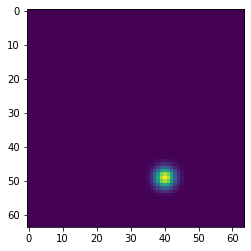

1


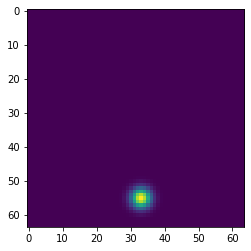

2


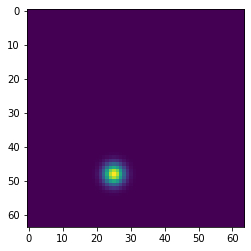

3


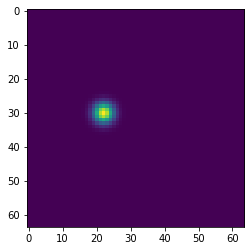

4


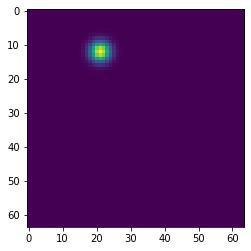

5


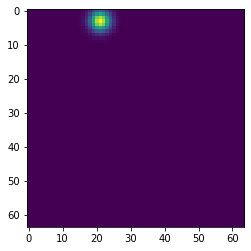

6


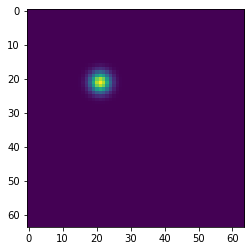

7


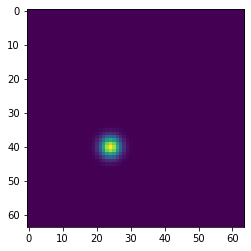

8


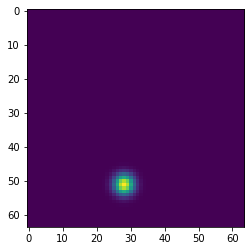

9


In [6]:
for i,x in enumerate(label[1]):
    plt.imshow(x)
    plt.show()
    print(i)

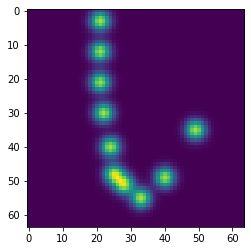

In [7]:
plt.imshow(np.sum(label[1],axis=0))

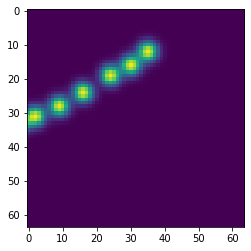

In [8]:
plt.imshow(np.sum(label[7],axis=0))

In [37]:
from keras.models import *
from keras.layers import *
import keras.backend as K
import tensorflow as tf


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # for head as intermediate supervision, use 'linear' as activation.
    # head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax', padding='same', name=str(hgid) + '_conv_1x1_parts_softmax')(head_parts)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
model = create_hourglass_network(12, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [40]:
model.compile(optimizer="Adam", loss=loss_func)

In [ ]:
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)
data = dataMachine.augmentEpoch(300)
model.fit(data[0], tf.ragged.constant(data[1]), batch_size=5,epochs=2)

In [24]:
out = model.predict(data[0])

10/10 [==============================] - 2s 229ms/step


In [25]:
np.shape(out)

(4, 300, 64, 64, 12)

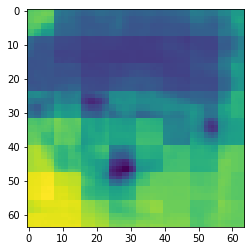

In [26]:
plt.imshow(np.sum(np.transpose(out[3][0],(2,0,1))[0:7],axis=0))

0.0042609787


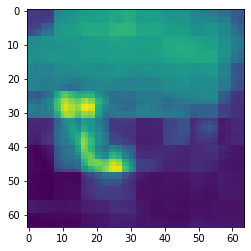

0.018625474


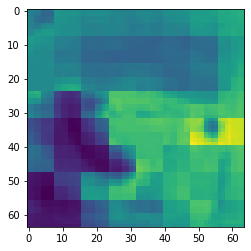

0.003564904


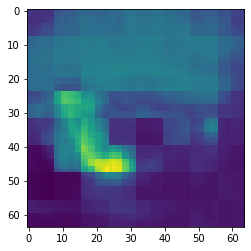

0.00058319094


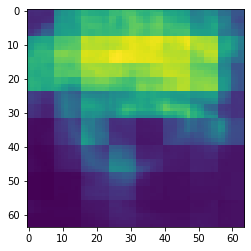

0.0023697943


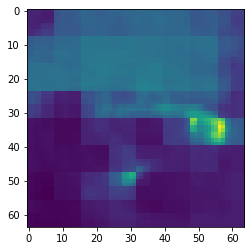

0.031174866


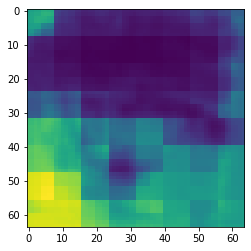

0.0022596146


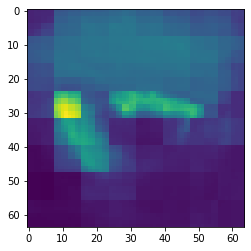

0.005172058


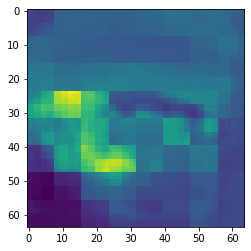

0.0013132769


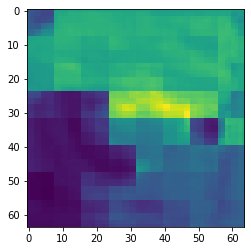

0.0035540778


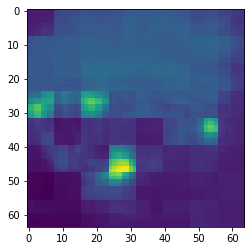

0.0017217919


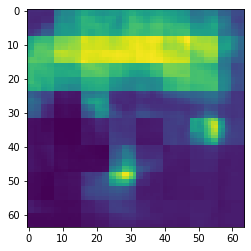

0.0019383262


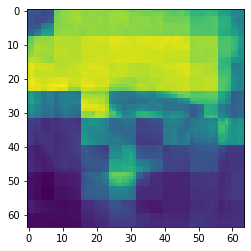

In [27]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

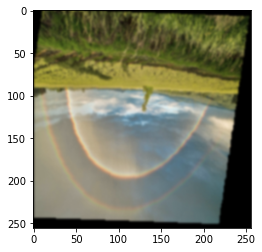

In [28]:
plt.imshow(data[0][0]/255.0)

In [104]:
gah = Image.open('brrrr.jpg')

In [105]:
gah = gah.resize((256,256))

In [106]:
out = model.predict(np.expand_dims(np.array(gah), axis=0))

1/1 [==============================] - 0s 247ms/step


In [107]:
np.shape(out)

(4, 1, 64, 64, 7)

0.005526531


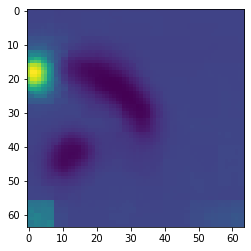

0.004737408


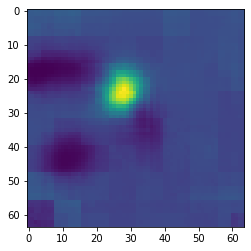

0.015574261


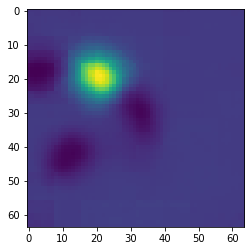

0.011428473


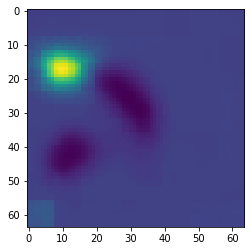

0.0055831005


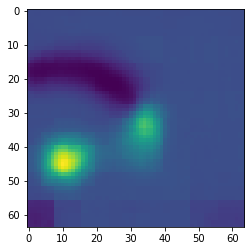

0.0073060193


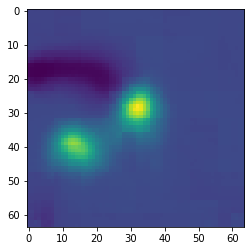

0.003621494


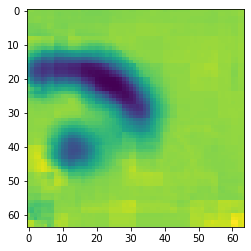

In [108]:
for x in np.transpose(out[3][0],(2,0,1)):
    print(np.min(x))
    plt.imshow(x)
    plt.show()

In [109]:
from scipy.ndimage import zoom

# Example: 2D array
array = np.array([[1, 2], [3, 4]])

# Upsample by a scale factor of 2
scale_factor = 2
upsampled_array = zoom(array, scale_factor, order=1)  # order=1 for bilinear interpolation

print(upsampled_array)

[[1 1 2 2]
 [2 2 2 3]
 [2 3 3 3]
 [3 3 4 4]]


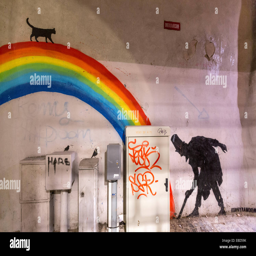

In [110]:
gah

In [ ]:
model.summary()